# Подключение необходимых библиотек

In [9]:

import gc
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torchinfo
from torchmetrics.classification import F1Score, Recall, Precision

# Считывание данных

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

data = datasets.ImageFolder(root='./simpsons_dataset', transform=data_transforms)
data_test = datasets.ImageFolder(root='./kaggle_simpson_testset', transform=data_transforms)
generator = torch.Generator().manual_seed(42)
data_train, data_valid = torch.utils.data.random_split(data, [0.9, 0.1], generator=generator)
data_image = {
    'train':
        data_train,
    'validation':
        data_valid,
    'test':
        data_test
}

classes_image = {
    'train':
        list(data.class_to_idx.keys()),
    'test':
        list(data_test.class_to_idx.keys())
}

loaders_image = {
    'train':
        torch.utils.data.DataLoader(data_image['train'], batch_size=64, shuffle=True),
    'validation':
        torch.utils.data.DataLoader(data_image['validation'], batch_size=64, shuffle=True),
    'test':
        torch.utils.data.DataLoader(data_image['test'], batch_size=64, shuffle=True)
}

# Визуализация картинок и их ключей

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


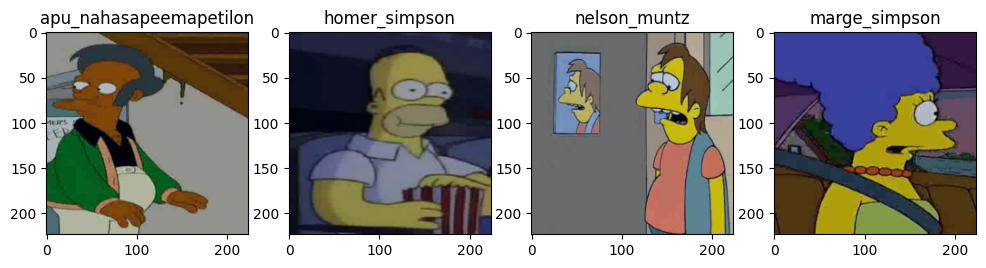

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


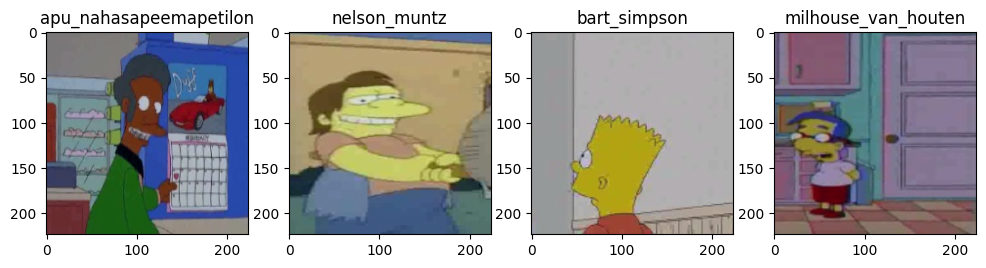

In [11]:

def image_shower(images, labels, phase, n=4):

    fig, axes = plt.subplots(1, 4)
    fig.set_figwidth(12)  # ширина и
    fig.set_figheight(6)
    for i, image in enumerate(images[:n]):
        image = image * 0.2 + 0.4
        axes[i].imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        axes[i].set_title(classes_image[phase][labels[i]])

    plt.show()
    

images, labels = next(iter(loaders_image['train']))
image_shower( images, labels, 'train')
images, labels = next(iter(loaders_image['test']))
image_shower( images, labels, 'test')

# Модель

In [16]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 42))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =0.001, momentum = 0.9)  
    
mcf1s = F1Score(task="multiclass", num_classes=42)
recall = Recall(task="multiclass", num_classes=42)
prec = Precision(task="multiclass", num_classes=42)

print(torchinfo.summary(model, input_size = (64, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 42]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]   

# Обучение

Epoch 1/20
----------
train loss: 3.0631, acc: 0.1628
validation loss: 2.7562, acc: 0.3015
Epoch 2/20
----------
train loss: 2.5389, acc: 0.4131
validation loss: 2.2499, acc: 0.5485
Epoch 3/20
----------
train loss: 2.0436, acc: 0.5612
validation loss: 1.8124, acc: 0.6163
Epoch 4/20
----------
train loss: 1.7003, acc: 0.6154
validation loss: 1.5636, acc: 0.6407
Epoch 5/20
----------
train loss: 1.4889, acc: 0.6484
validation loss: 1.3943, acc: 0.6742
Epoch 6/20
----------
train loss: 1.3533, acc: 0.6739
validation loss: 1.3116, acc: 0.6842
Epoch 7/20
----------
train loss: 1.2579, acc: 0.6926
validation loss: 1.2348, acc: 0.6966
Epoch 8/20
----------
train loss: 1.1866, acc: 0.7054
validation loss: 1.1910, acc: 0.7062
Epoch 9/20
----------
train loss: 1.1279, acc: 0.7168
validation loss: 1.1357, acc: 0.7143
Epoch 10/20
----------
train loss: 1.0804, acc: 0.7255
validation loss: 1.0921, acc: 0.7272
Epoch 11/20
----------
train loss: 1.0375, acc: 0.7346
validation loss: 1.0817, acc: 0.72

Text(0, 0.5, 'Loss')

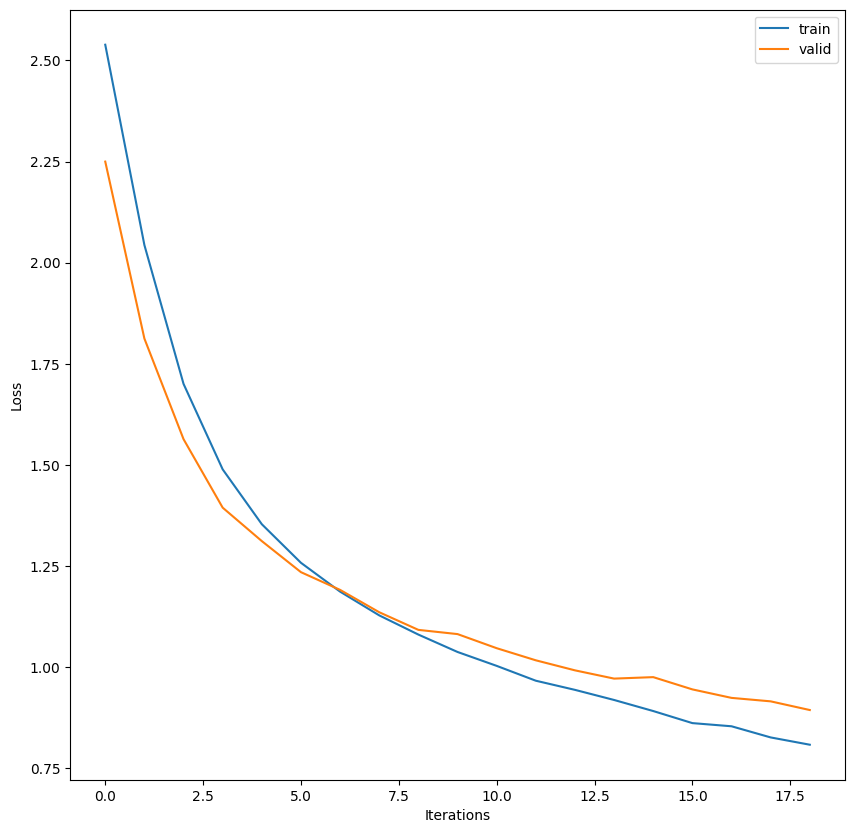

In [13]:
train_losses = []
valid_losses = []


def train_model(model, criterion, optimizer, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_image[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_image[phase])
            epoch_acc = running_corrects.double() / len(data_image[phase])
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                valid_losses.append(epoch_loss)
                if best_acc < epoch_acc: 
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model.load_state_dict(best_model_wts)

train_model(model, criterion, optimizer)
fig = plt.figure(figsize=(10, 10))

plt.plot(train_losses[1:], label='train')
plt.plot(valid_losses[1:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')


# Точность

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


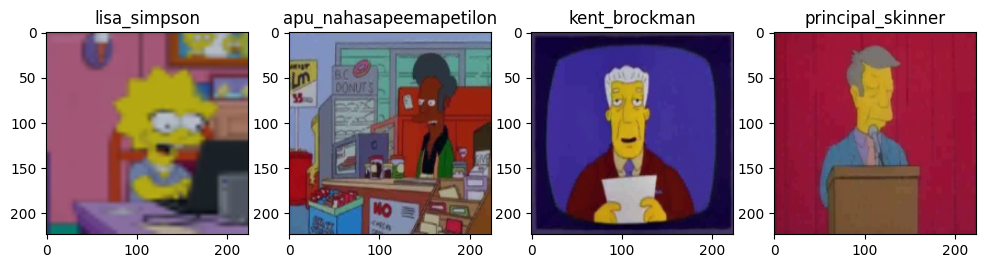

F1-score of the network on the 990 validation images: 77.4747 %


In [15]:
f1_score = F1Score(task = "multiclass", num_classes = 42)
with torch.no_grad():

    total = 0
    all_labels = []
    all_predicts = []

    for i, (images, labels) in enumerate(loaders_image['test']):
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        if not i:
            image_shower(images.cpu(), predicted.cpu(),'train')

        for a, res in enumerate(predicted):
            if classes_image['train'][res] == classes_image['test'][labels[a]]:
               predicted[a] = labels[a]

        all_labels = np.concatenate((all_labels, labels.cpu()), axis = 0)
        all_predicts = np.concatenate((all_predicts, predicted.cpu()), axis = 0)

        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    # print('Accuracy of the network on the {} validation images: {:.4f} %'.format(total, 100 * accuracy_score(all_labels, all_predicts)))
    # print('Precision of the network on the {} validation images: {:.4f} %'.format(total, 100 * precision_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    # print('Recall of the network on the {} validation images: {:.4f} %'.format(total, 100 * recall_score(all_labels, all_predicts, average = 'weighted', zero_division = 0)))
    print('F1-score of the network on the {} validation images: {:.4f} %'.format(total, 100 * f1_score(torch.tensor(all_predicts), torch.tensor(all_labels))))
